### Tinkering with DNN configurations to classify CIFAR-10 

##### Isidoros Tsaousis-Seiras, AEM: 10042, THMMY
[github repository](https://github.com/isidorostsa/dnn-cifar)

In [62]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import KFold
from itertools import product

Gobal definitions

In [63]:
DIM = 32
CHANNELS = 3
CLASSES = 10

LOSS_FN = nn.CrossEntropyLoss()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert DEVICE.type == 'cuda'

Import simple helper functions

In [64]:
from helpers import *

Generic training and testing loops

In [65]:
def train_model(model, trainloader, testloader, optimizer, loss_fn = LOSS_FN, epochs=10, history={}, verbose=True):
    if not history:
        history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

    times = []

    batches = len(trainloader)

    if verbose:
        print(f'Training on {DEVICE} for {epochs} epochs, {batches} batches per epoch')

    for epoch in range(epochs):
        time_start = time.time()
        running_loss = 0.0
        train_correct = 0
        total = 0

        prints_per_epoch = 5

        for i, data in enumerate(trainloader):
            # computation is faster on GPU
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # zeroing the gradients on every batch
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

            if verbose:
                if batches < prints_per_epoch:
                    prints_per_epoch = 1
                if i % (batches//prints_per_epoch) == (batches//prints_per_epoch)-1:
                    print(f'Epoch {epoch+1}, batch {i+1}/{batches}: loss = {loss:.3f}')

        loss = running_loss / batches
        accuracy = train_correct / total

        model.eval()
        test_loss, test_accuracy = test_model(model, testloader)
        model.train()

        history['train_loss'].append(loss)
        history['train_accuracy'].append(accuracy)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        if verbose:
            print(f'Epoch {epoch+1}: train loss = {loss:.3f}, train accuracy = {100*accuracy:.3f}%')
            print(f'Epoch {epoch+1}: test loss = {test_loss:.3f}, test accuracy = {100*test_accuracy:.3f}%')
        
        interval = time.time() - time_start

        times.append(interval)

    avg_time = np.mean(times)
    history['time_per_epoch'] = avg_time
    
    return history

        
# model.eval() is handled by the caller
def test_model(model, testloader, loss_fn = LOSS_FN):
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)

            # get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # update counts
            total += labels.size(0)
            loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item()

    batches = len(testloader)

    return loss/batches, correct/total

Let's load and inspect the data. The images have been configured to have a 50% chance of being flipped horizontally and tilted to up to 15 degrees.

Files already downloaded and verified


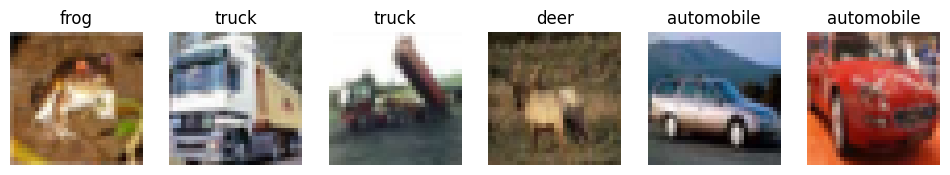

In [66]:
trainset, testset = fetch_datasets()
cifar_len = len(trainset)
show_images(trainset.data, trainset.targets, trainset.classes)
models = {}

### Trial one: From the ground up.

The input of the model will be a vector of the brightness level of each of the red, green and blue colors, and the output will be the class in which it belongs (10 classes: car, dog, frog etc.). In the following document different methods of increasing the accuracy of the linear model will be showcased, and in the end there is a comparison with a simple CNN model.

Let's start the trials with a simple sequenced model with three layers.

In [67]:
model_1_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["SGD"] = model_1_1

It will be trained with simple SGD, for 20 epochs. In the meantime we will be collecting performance metrics on each epoch. We will be using cross validation as the loss function throughout testing. A large batch size leads to greatly reduced time for training, so for the purposes of the document a batch size of 512 is chosen throughout most of the examples.

Files already downloaded and verified
Elapsed time: 159.661 seconds


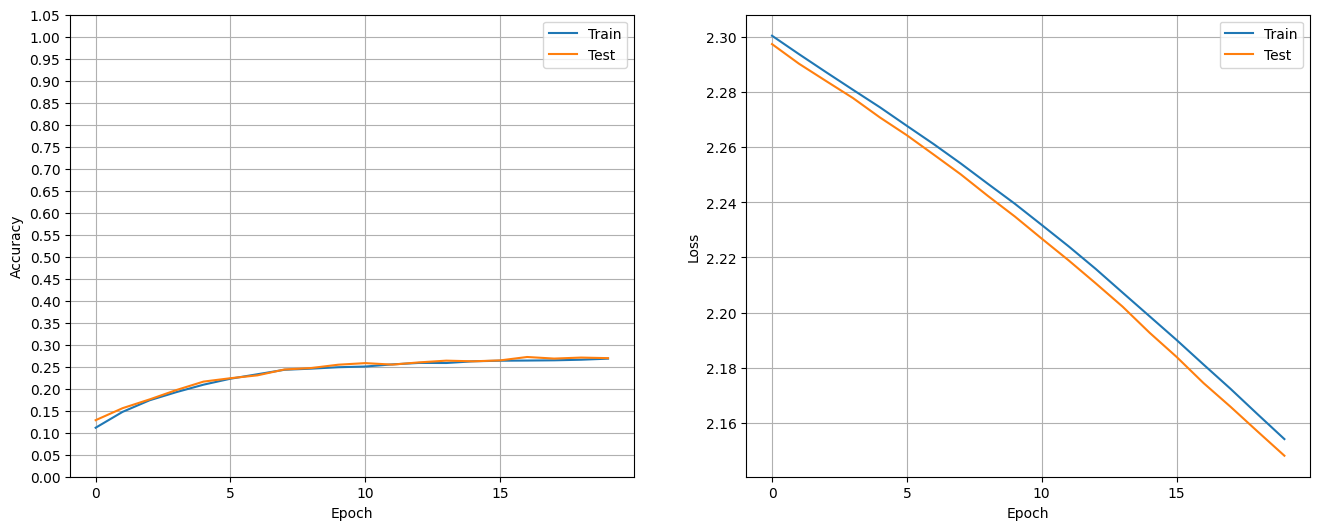

In [68]:
epochs_1_1 = 20
batch_size_1_1 = 512

trainloader, testloader = get_loaders(batch_size_1_1)

optimizer_1_1 = torch.optim.SGD(model_1_1.parameters(), lr=0.001, momentum=0.0)
with Timer():
    history_default = train_model(model_1_1, trainloader, testloader, optimizer_1_1, epochs=epochs_1_1, verbose=False)

plot_accuracy_loss(history_default)

While using `SGD` yields a steadily increasing accuracy, it is quite slow. We can utilize momentum, a higher order term, to possibly speed this up.

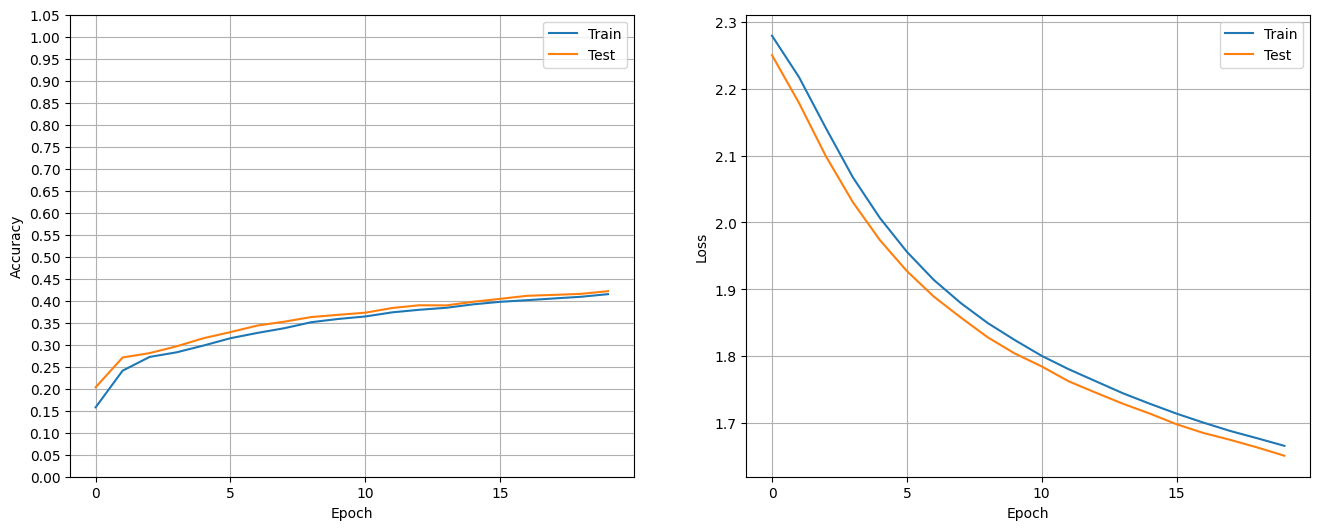

In [204]:
model_1_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["SGD with momentum"] = model_1_2

optimizer_1_2 = torch.optim.SGD(model_1_2.parameters(), lr=0.001, momentum=0.9)
epochs_1_2 = 20 # keep the same number of epochs
batch_size_1_2 = 512 # keep the same batch size

with Timer():
    history_momentum = train_model(model_1_2, trainloader, testloader, optimizer_1_2, epochs=epochs_1_2, verbose=False)

plot_accuracy_loss(history_momentum)

The use of momentum resulted in the model reaching ~25% accuracy in 2 epochs instead of the 12 it took before. Using the `adam` optimizer hastens it further.

Elapsed time: 300.271 seconds


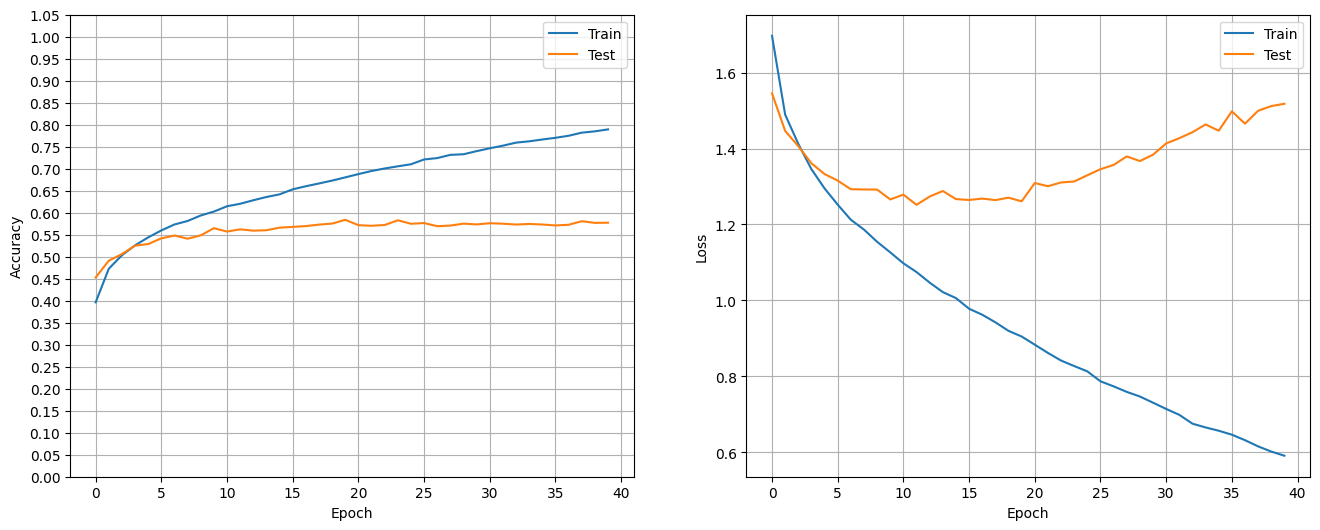

In [70]:
model_1_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["Adam"] = model_1_3

optimizer_1_3 = torch.optim.Adam(model_1_3.parameters(), lr=0.001)

epochs_1_3 = 40 # double the number of epochs to observe the effect of overfitting
batch_size_1_3 = 512 # keep the same batch size

with Timer():
    history_adam = train_model(model_1_3, trainloader, testloader, optimizer_1_3, epochs=epochs_1_3, verbose=False)

plot_accuracy_loss(history_adam)

Now ~25% accuracy is reached in the first epoch. After ~20 epochs the test accuracy peaks at ~57%. The new problem is that the model starts overfitting after that. 

#### Overfitting
There are many ways to combat overfitting without compromising on test accuracy. Some of those will be showcased in the following sections, starting with `weight decay`.

##### 1. Weight Decay
Overfitting models usually present large weights, `weight decay` helps avoid this by adding a term that normalizes large weights. The derivative of `weight_decay * weight_i^2` with respect to `weight_i` is `2 * weight_decay * weight_i`. So, the update to each weight is proportional to its current value. 

This means that larger weights are shrunk more than smaller weights at each update, which helps to prevent the weights from growing too large and causing overfitting.

Elapsed time: 266.993 seconds


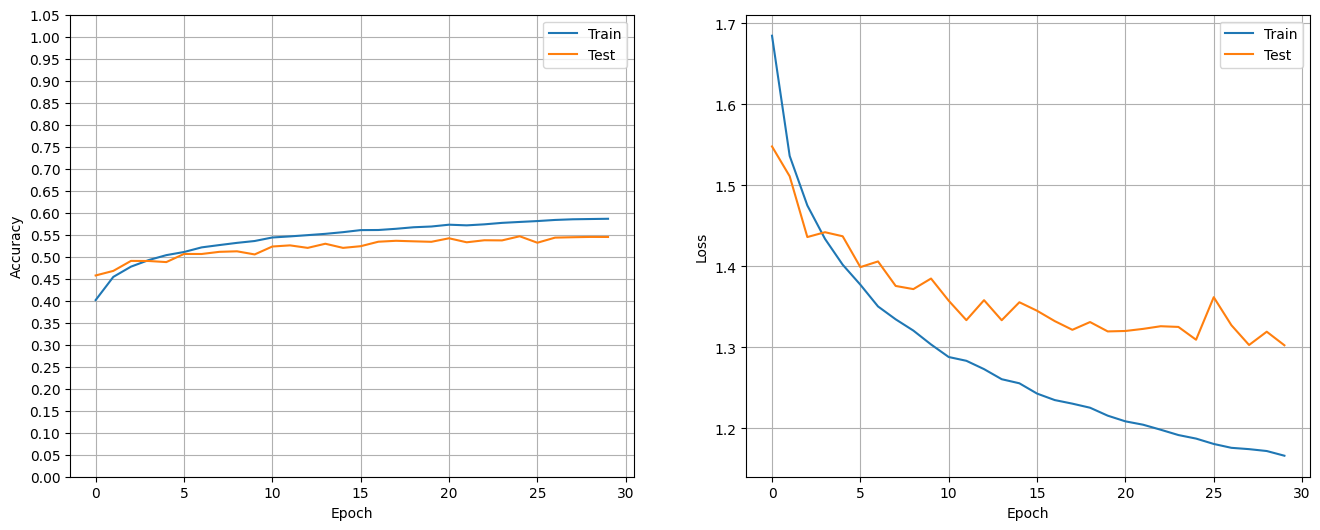

In [103]:
model_1_4 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["Adam with Weight Decay 0.0001"] = model_1_4

optimizer_1_4 = torch.optim.Adam(model_1_4.parameters(), lr=0.001, weight_decay=0.0001) # weight decay term
epochs_1_4 = 30 # slightly less epochs as the overfitting is still visible
batch_size_1_4 = 512 # keep the same batch size

with Timer():
    history_adam_wd = train_model(model_1_4, trainloader, testloader, optimizer_1_4, epochs=epochs_1_4, verbose=False)

plot_accuracy_loss(history_adam_wd)

The model is overfitting less while achieving the same accuracy. It is possible that increasing the `weight decay` coefficient will further lesser the effects of overfitting.

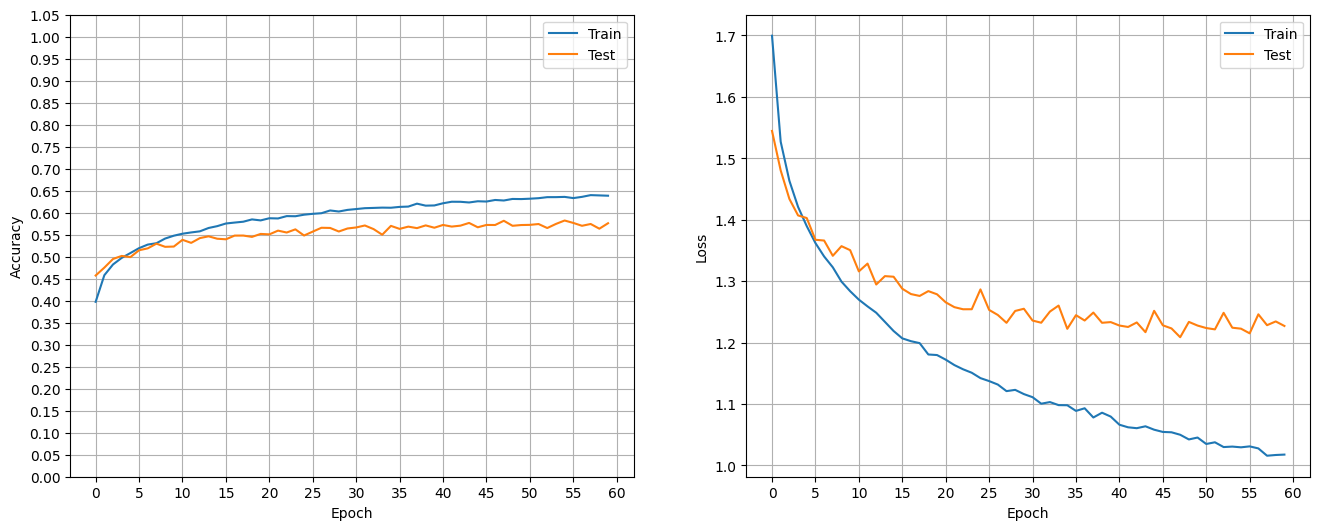

In [183]:
model_1_5 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["Adam with Weight Decay 0.001"] = model_1_5

optimizer_1_5 = torch.optim.Adam(model_1_5.parameters(), lr=0.001, weight_decay=0.001) # increase the weight decay by a factor of 10
epochs_1_5 = 60 # Increase the number of epochs since there is a lesser chance of overfitting
batch_size_1_5 = 512 # keep the same batch size

with Timer():
    history_adam_wd_2 = train_model(model_1_5, trainloader, testloader, optimizer_1_5, epochs=epochs_1_5, verbose=False)

plot_accuracy_loss(history_adam_wd_2)

Increasing the `weight decay` factor further reduced overfitting, while also increasing the accuracy, as can be seen in the following graph.

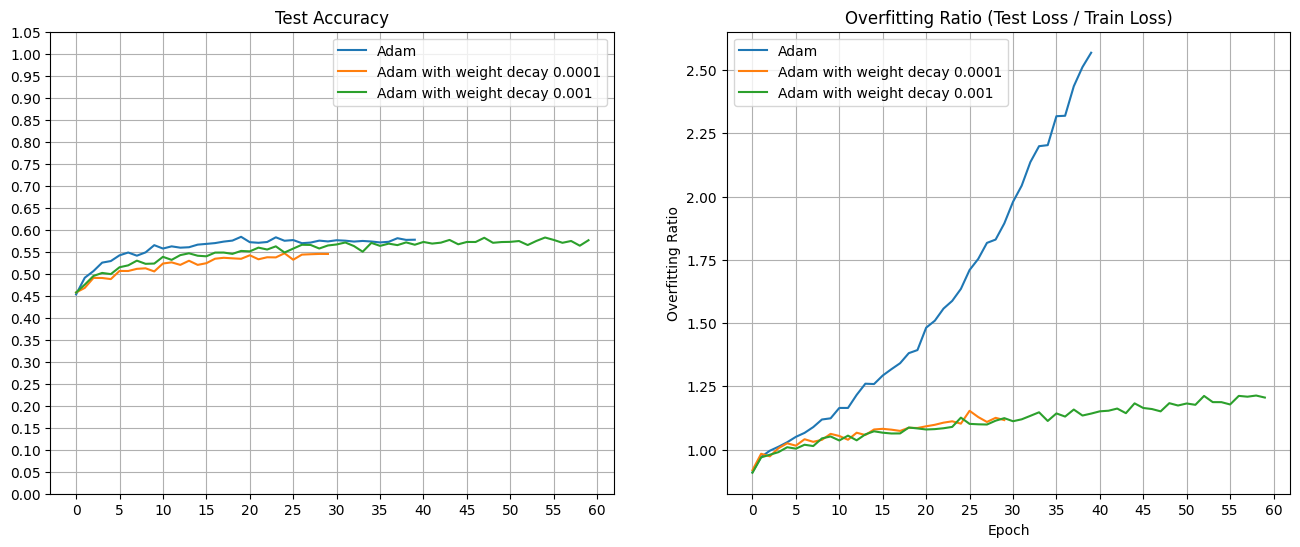

In [243]:
compare_accuracy_and_overfitting(
    {
        'Adam': history_adam,
        'Adam with weight decay 0.0001': history_adam_wd,
        'Adam with weight decay 0.001': history_adam_wd_2
    }
)

#### 2. Dropout

Another popular way to reduce overfitting is the use of dropout layers. Dropout layers work by randomly setting a fraction of a layer's input units to 0 at each update during training time. This introduces noise into the training process, which can help to improve the generalization ability of the model. The fraction of input units that are set to 0 is a parameter that can be tuned for each dropout layer. Let's start by using two dropout layers. After Weight decay was benchmarked at `1e-3` and `1e-4`, the latter was chosen. The former yielded a model with ~48% accuracy after 60 epochs of training.

Elapsed time: 534.015 seconds


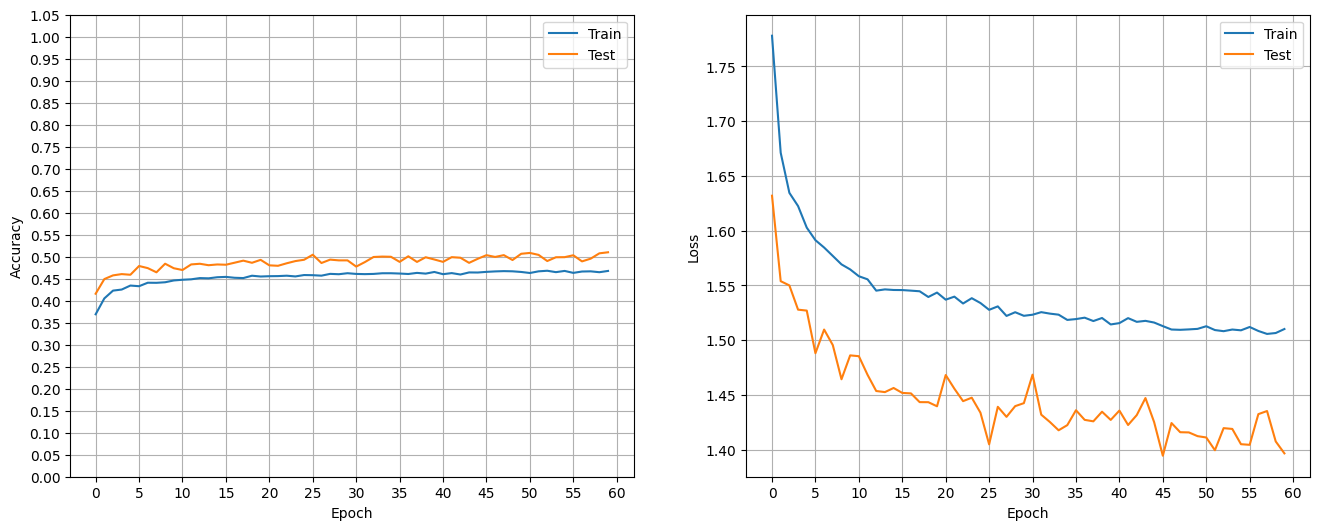

In [133]:
model_1_6 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["Adam with Dropout"] = model_1_6

optimizer_1_6 = torch.optim.Adam(model_1_6.parameters(), lr=0.001, weight_decay=0.0001)
epochs_1_6 = 60 # keep the same number of epochs
batch_size_1_6 = 512 # keep the same batch size

with Timer():
    history_adam_dropout = train_model(model_1_6, trainloader, testloader, optimizer_1_6, epochs=epochs_1_6, verbose=False)

plot_accuracy_loss(history_adam_dropout)

The figures concerning overfitting are the following

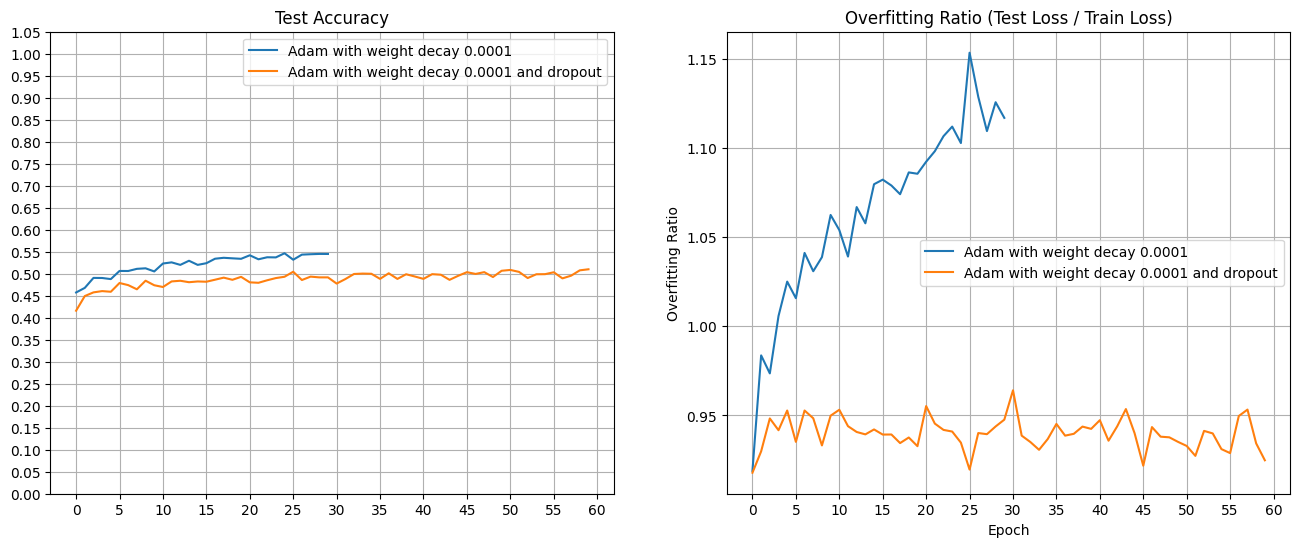

In [244]:
compare_accuracy_and_overfitting(
    {
        'Adam with weight decay 0.0001': history_adam_wd,
        'Adam with weight decay 0.0001 and dropout': history_adam_dropout,
    }
)

The dropout layers prevented the model from overfitting at all, while reaching a higher accuracy than previous models, but this leaves room to add more perceptron layers without a fear of overfitting. Let's try the same configuration with an extra layer.

Elapsed time: 463.894 seconds


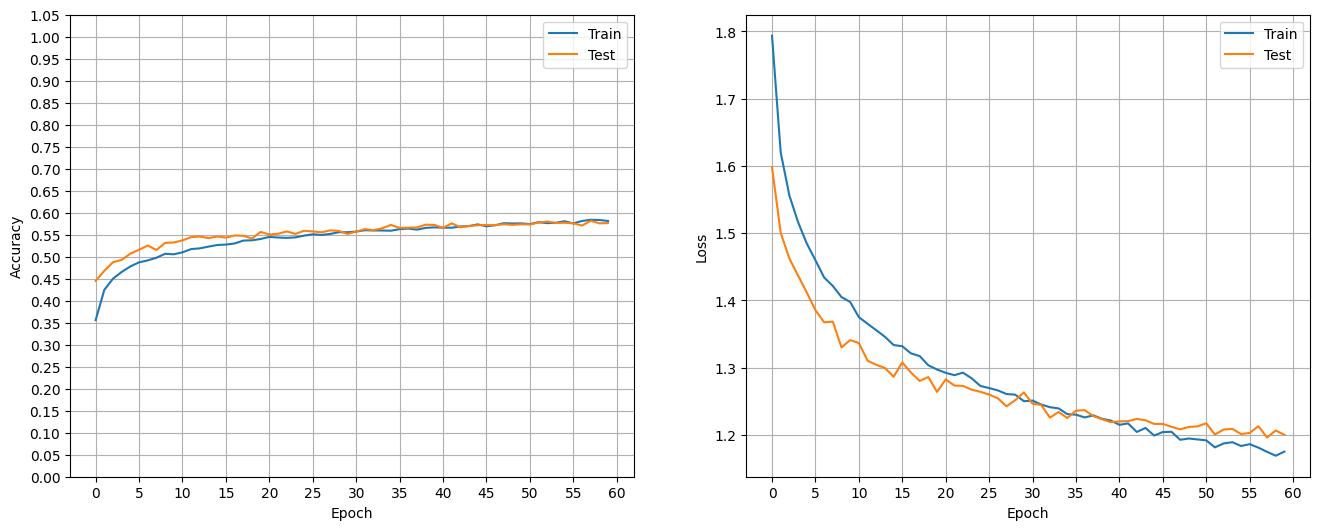

In [76]:
model_1_7 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM*CHANNELS, DIM*DIM),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(DIM*DIM, DIM*DIM),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(DIM*DIM//4, CLASSES)
).to(DEVICE)

models["Adam with Dropout and more layers"] = model_1_7

optimizer_1_7 = torch.optim.Adam(model_1_7.parameters(), lr=0.001, weight_decay=0.0001)
epochs_1_7 = 60 # Use more epochs to allow the model to converge
batch_size_1_7 = 512 # keep the same batch size

with Timer():
    history_adam_dropout_2 = train_model(model_1_7, trainloader, testloader, optimizer_1_7, epochs=epochs_1_7, verbose=False)

plot_accuracy_loss(history_adam_dropout_2)

The extra layer offers a minimal increase in accuracy (<1%). Training was halted at ~60 epochs the test loss becomes greater that the training loss, which shows potential overfitting. For the subsequent trials, the model used will be `Adam` with a weight decay of `10e-3` and two dropout layers.

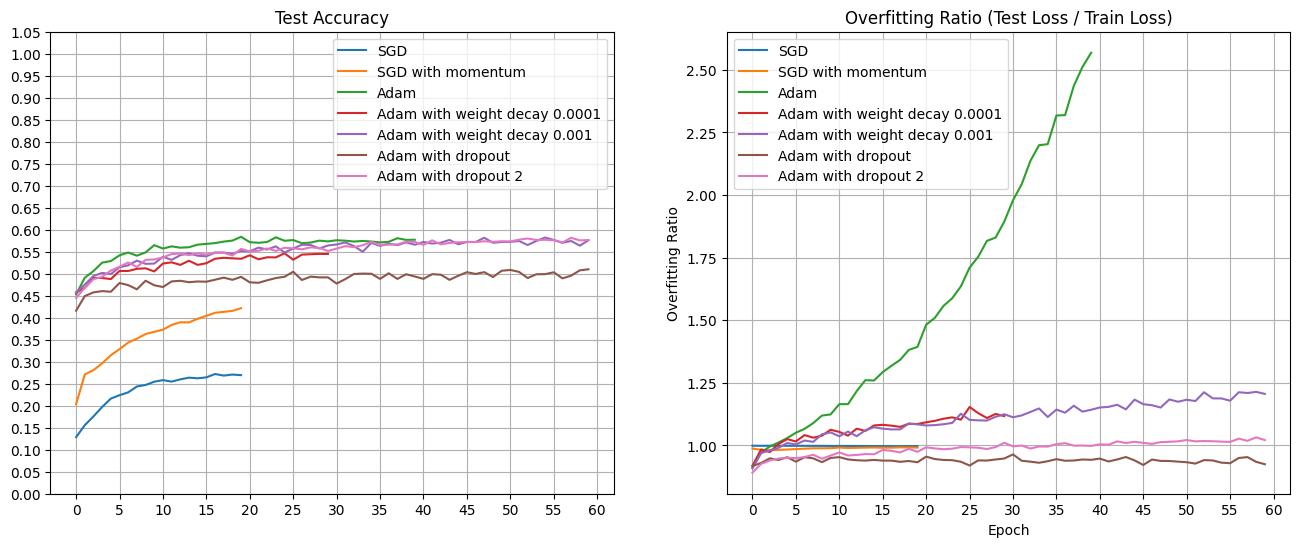

In [245]:
compare_accuracy_and_overfitting(
    {
        "SGD": history_default,
        "SGD with momentum": history_momentum,
        "Adam": history_adam,
        "Adam with weight decay 0.0001": history_adam_wd,
        "Adam with weight decay 0.001": history_adam_wd_2,
        "Adam with dropout": history_adam_dropout,
        "Adam with dropout 2": history_adam_dropout_2
    }
)

### Trial two: Too many details.

In any image dataset there is bound to be noise. Noise in this context might mean literal imperfections in the pictures, but it can also mean extra details in the background, unrelated to the depicted subject (e.g. the blue sky or vignette in the edges). We can assume that such imperfections will be present at an equal rate throughout all the images, and thus will not contribute any information, and they can thus be detected and removed mathematically when the dimension is reduced and only the features contributing the highest standard deviation will be kept.

It is also known that linear models do not generalize to high dimensions well, so by reducing the number of dimensions we can hit two birds with one stone.

The first method of feature selection we will use is going to be the $\chi^2$ test.

#### 1.  $\chi^2$ Feature selection

This requires some setup first

In [78]:
# batch size is as long as the number of images
trainloader, testloader = get_loaders(len(trainset))

data_train, labels_train = next(iter(trainloader))
data_train = data_train.view(len(data_train), -1).numpy()
labels_train = labels_train.numpy()

data_test, labels_test = next(iter(testloader))
data_test = data_test.view(len(data_test), -1).numpy()
labels_test = labels_test.numpy()

# values must be positive to utilize chi2
main_val = min(data_test.min(), data_train.min())
data_train_shifted = data_train + abs(main_val)
data_test_shifted = data_test + abs(main_val)

Files already downloaded and verified


The Chi2 selector will be used for a 2/3 reduction from 3072 to 1024 features.

In [79]:
chi2_selector = SelectKBest(chi2, k=DIM*DIM)

chi2_selector.fit(data_train_shifted, labels_train)

kbest_train = chi2_selector.transform(data_train)
kbest_test = chi2_selector.transform(data_test)

x_train = torch.from_numpy(kbest_train).float().to(DEVICE)
y_train = torch.from_numpy(labels_train).long().to(DEVICE)

x_test = torch.from_numpy(kbest_test).float().to(DEVICE)
y_test = torch.from_numpy(labels_test).long().to(DEVICE)
chi2_test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

chi2_dataset = torch.utils.data.TensorDataset(x_train, y_train)

Let's make a model to train with the new data. The input dimension is reduced to 1024, while the subsequent layers stay the same.
We will use the same parameters as in the first example, changing one variable at a time.

Elapsed time: 13.275 seconds


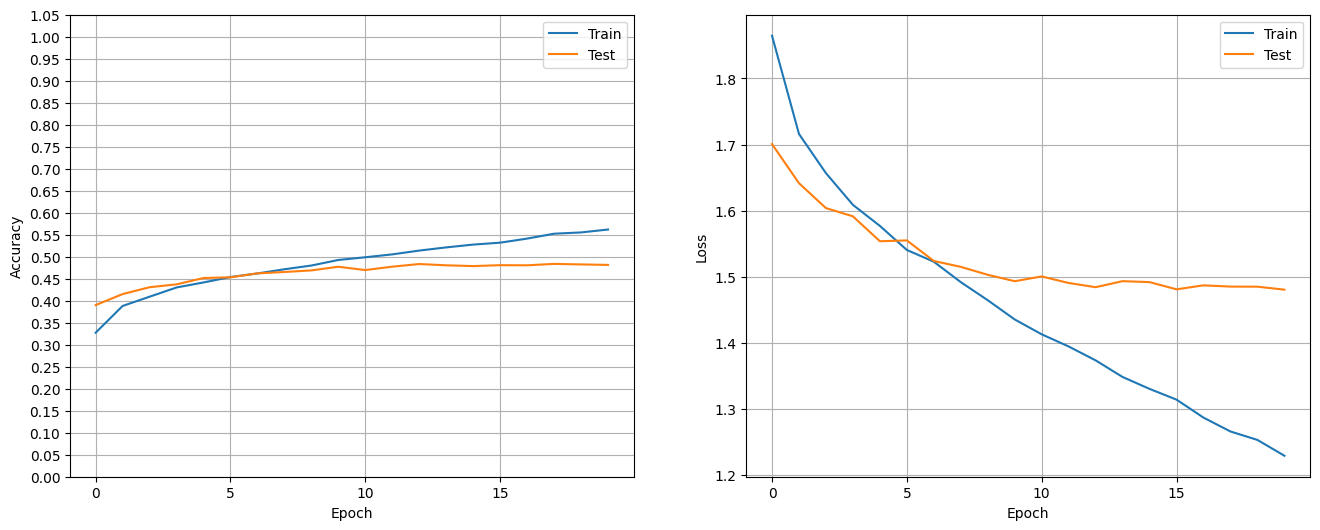

In [80]:
model_2_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM, DIM*DIM),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Linear(DIM*DIM//4, 10)
).to(DEVICE)

models["Adam with chi2"] = model_2_1

optimizer_2_1 = torch.optim.Adam(model_2_1.parameters(), lr=0.001)
epochs_2_1 = 20
batch_size_2_1 = 512

chi2_testloader = torch.utils.data.DataLoader(chi2_test_dataset, batch_size=batch_size_2_1, shuffle=False)
chi2_trainloader = torch.utils.data.DataLoader(chi2_dataset, batch_size=batch_size_2_1, shuffle=True)

with Timer():
    history_chi2 = train_model(model_2_1, chi2_trainloader, chi2_testloader, optimizer_2_1, epochs=epochs_2_1, verbose=False) 

plot_accuracy_loss(history_chi2)

Remarkably the training of this model took less that 17 seconds, compared to the 200+ seconds needed for the first model (same number of epochs, same batch size). Unfortunately the accuracy dropped significantly, from ~57% to less than 50%. Valuable pieces of information were pruned along with the irrelevant noise. A more sophisticated feature selection method is PCA. 

#### 2. PCA Feature selection
Instead of completely pruning certain features, PCA projects the space to a lower dimension. Any transformed sample will be a linear combination of the features of the original sample, with the less important features having a low significance.

In [8]:
trainloader, testloader = get_loaders(cifar_len)

data_train, labels_train = next(iter(trainloader))
data_train = data_train.view(len(data_train), -1)  # Flatten the images

data_test, labels_test = next(iter(testloader))
data_test = data_test.view(len(data_test), -1)  # Flatten the images

mean_train = data_train.mean(dim=0)
data_train = data_train - mean_train
data_test = data_test - mean_train

U, S, V = torch.linalg.svd(data_train, full_matrices=False)

Files already downloaded and verified


As in the previous example, the target feature size will be 1/3 of the original.

In [48]:
n_components = DIM*DIM

V_reduced = V[:, :n_components]

pca_train = torch.matmul(data_train, V_reduced)
pca_test = torch.matmul(data_test, V_reduced)

x_pca_train = pca_train.float().to(DEVICE)
y_pca_train = labels_train.long().to(DEVICE)

x_pca_test = pca_test.float().to(DEVICE)
y_pca_test = labels_test.long().to(DEVICE)

pca_test_dataset = torch.utils.data.TensorDataset(x_pca_test, y_pca_test)
pca_train_dataset = torch.utils.data.TensorDataset(x_pca_train, y_pca_train)

The same model as with the $\chi^2$ case will be used.

Elapsed time: 20.490 seconds


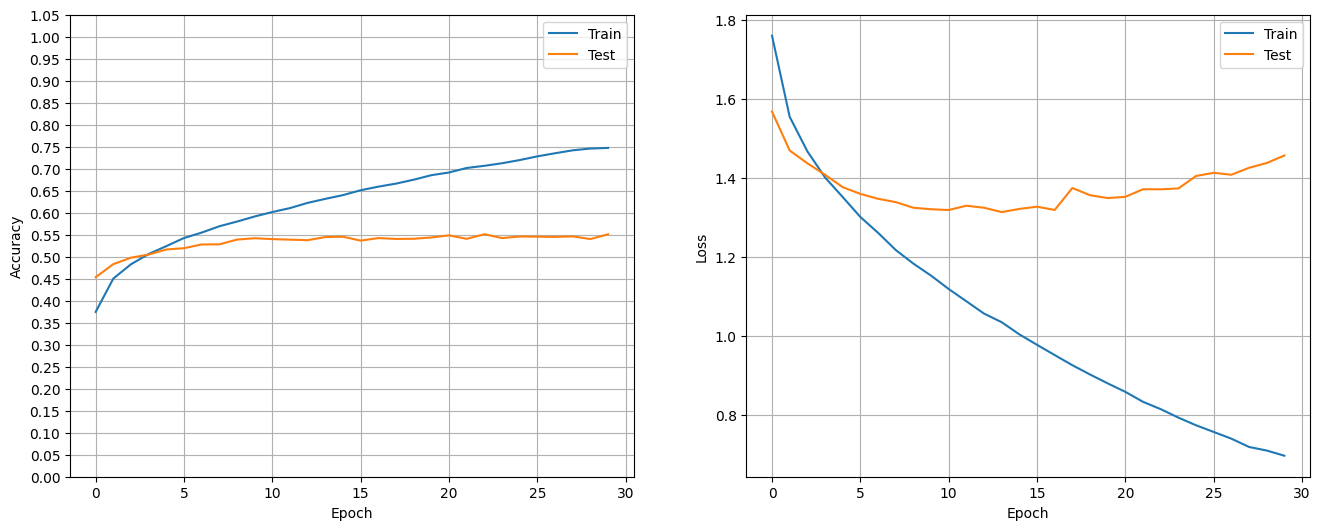

In [81]:
model_2_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(DIM*DIM, DIM*DIM),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(DIM*DIM, DIM*DIM//4),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(DIM*DIM//4, 10)
).to(DEVICE)

models["Adam with PCA"] = model_2_2

optimizer_2_2 = torch.optim.Adam(model_2_2.parameters(), lr=0.001)
epochs_2_2 = 30
batch_size_2_2 = 512

pca_testloader = torch.utils.data.DataLoader(pca_test_dataset, batch_size=batch_size_2_2, shuffle=False)
pca_trainloader = torch.utils.data.DataLoader(pca_train_dataset, batch_size=batch_size_2_2, shuffle=True)

with Timer():
    history_pca = train_model(model_2_2, pca_trainloader, pca_testloader, optimizer_2_2, epochs=epochs_2_2, verbose=False)

plot_accuracy_loss(history_pca)

This model gives the close to the best results, with a ~55% accuracy score and little overfitting, while training significantly faster than the other models. 

The high accuracy of this model suggests that there is much redundancy in the data, possibly due to the trichromatic nature of the data.

#### 3. Partially connected layer
The next feature selection approach is centered around this idea, the three colors will be combined to one, as the network sees fit. This will be done by adding an extra layer, that will essentially learn to convert color images to black and white, while retaining the most information possible. 

In [28]:
class Pixel_mapping_layer(nn.Module):
    def __init__(self):
        super(Pixel_mapping_layer, self).__init__()
        self.linear = nn.Linear(DIM*DIM*CHANNELS, DIM*DIM)

        # Initialize weights and biases
        with torch.no_grad():
            self.linear.weight.fill_(0)
            self.linear.bias.fill_(0)
            for i in range(DIM*DIM):
                # equal to 1
                self.linear.weight[i, i] = torch.rand(1)
                self.linear.weight[i, i + DIM*DIM] = torch.rand(1)
                self.linear.weight[i, i + DIM*DIM*2] = torch.rand(1)

        # Create mask for non-zero weights
        self.mask = self.linear.weight.data != 0
        self.mask = self.mask.float().to(DEVICE)

        # Register backward hook
        self.linear.weight.register_hook(self.backward_hook)

    def backward_hook(self, grad):
        return grad * self.mask

    def forward(self, x):
        return self.linear(x)

This layer will be used in the same way the pca or chi2 step was used previously. It is worth noting that this will lead to an increased number of learnable non-zero parameters, albeit a small number of them (3072). In practice this has as many neurons as the previous fully connected models, however this is a quality of implementation issue.

In [219]:
class Pixel_mapped_model(nn.Module):
    def __init__(self):
        super(Pixel_mapped_model, self).__init__()

        self.mapping_layer = Pixel_mapping_layer() # DIM*DIM*CHANNELS -> DIM*DIM
        self.layer2 = nn.Linear(DIM*DIM, DIM*DIM)
        self.layer3 = nn.Linear(DIM*DIM, DIM*DIM//4)
        self.layer4 = nn.Linear(DIM*DIM//4, 10)

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(-1, DIM*DIM*CHANNELS)

        x = self.mapping_layer(x)
        x = self.activation(x)

        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.layer4(x)

        return x

model_2_3 = Pixel_mapped_model().to(DEVICE)

models["Adam with pixel mapping"] = model_2_3

It is using an activation function after the mapping in order ta take advantage of the learnable parameters.

Files already downloaded and verified


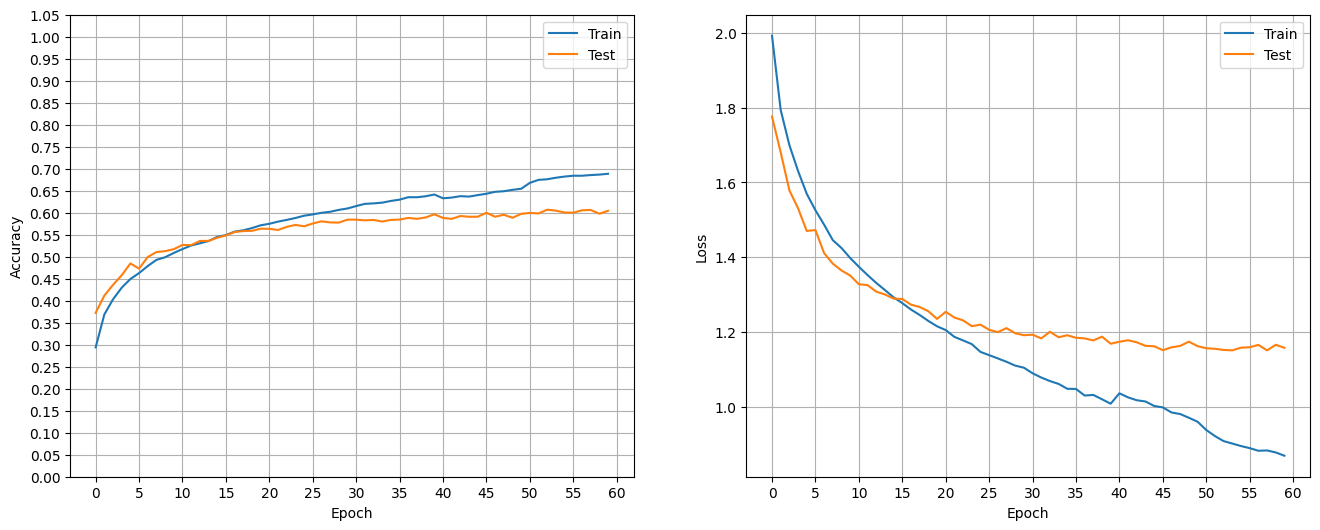

In [136]:
optimizer_2_3 = torch.optim.Adam(model_2_3.parameters(), lr=0.001)
epochs_2_3 = 60
batch_size_2_3 = 512

trainloader, testloader = get_loaders(batch_size_2_3)

with Timer():
    history_smart = train_model(model_2_3, trainloader, testloader, optimizer_2_3, epochs=epochs_2_3, verbose=False)

plot_accuracy_loss(history_smart)

This model yields the best results yet with ~60% accuracy, higher than both the chi2 method and the pca method. An interesting benefit of using this sort of method is that it allows for human-interpretable results: we can see how each image is turned from colored to black and white. This is also the case for the chi2 results.

Files already downloaded and verified


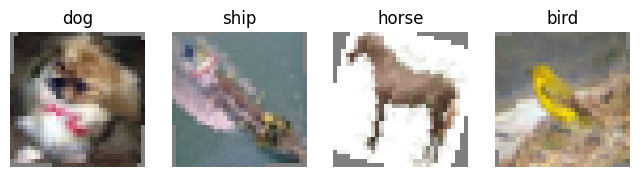

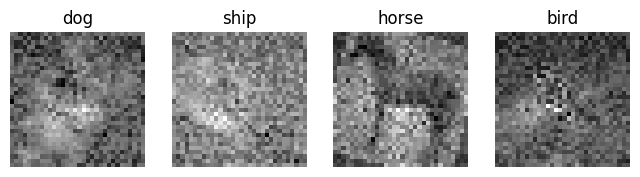

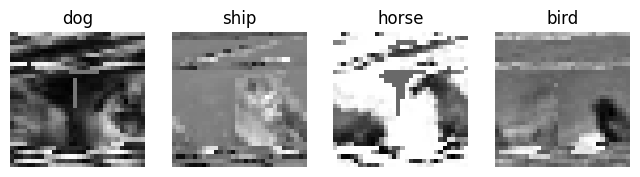

In [181]:
loader_small, _ = get_loaders(4)

inputs, labels = next(iter(loader_small))

# unnormalize the inputs
inputs_unnormalized = inputs.cpu().permute(0, 2, 3, 1) * 0.5 + 0.5

show_images(inputs_unnormalized, labels.cpu(), trainset.classes, n_images=4)

# run the model on the inputs
first_layer = model_2_3.mapping_layer(inputs.to(DEVICE).view(-1, DIM*DIM*CHANNELS))

# reshape the outputs to be 4D
first_layer = first_layer.view(-1, 32, 32, 1)
first_layer = first_layer.cpu().detach().permute(0, 1, 2, 3)

# show the outputs of the first layer
show_images(first_layer, labels.cpu(), trainset.classes, n_images=4, grayscale=True)

# calculate the chi2 version of the inputs
inputs = inputs.view(len(inputs), -1).numpy()
inputs_chi2 = chi2_selector.transform(inputs)
show_images(inputs_chi2.reshape(-1, 32, 32, 1), labels.cpu(), trainset.classes, n_images=4, grayscale=True)

The color conversion happens on the first layer, which means that no information about the image itself has been collected yet. In other words, all images are processed in the same way, so the ony decision left to the model is what importance each color has for every pixel, given its position. Let's inspect the weights and see what it came up with.

Average absolute value of the weights for the red channel: 0.416
Average absolute value of the weights for the green channel: 0.373
Average absolute value of the weights for the blue channel: 0.431


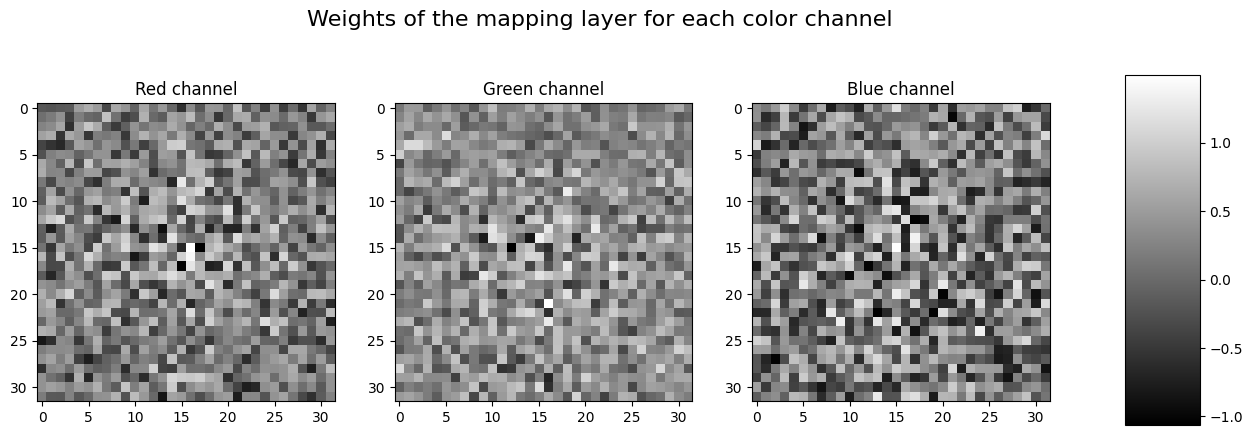

In [178]:
# get the weights of the mapping layer
weights = model_2_3.mapping_layer.linear.weight.data

weights_r = np.zeros(DIM*DIM)
weights_g = np.zeros(DIM*DIM)
weights_b = np.zeros(DIM*DIM)

for i in range(DIM*DIM):
    weights_r[i] = weights[i, i].item()
    weights_g[i] = weights[i, i + DIM*DIM].item()
    weights_b[i] = weights[i, i + DIM*DIM*2].item()

# Plot the weights of the mapping layer for each color channel
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

weights_r = weights_r.reshape(32, 32)
axs[0].imshow(weights_r, cmap='gray')
axs[0].set_title('Red channel')

weights_g = weights_g.reshape(32, 32)
axs[1].imshow(weights_g, cmap='gray')
axs[1].set_title('Green channel')

weights_b = weights_b.reshape(32, 32)
axs[2].imshow(weights_b, cmap='gray')
axs[2].set_title('Blue channel')

# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0].imshow(weights_r, cmap='gray'), cax=cbar_ax)

fig.suptitle('Weights of the mapping layer for each color channel', fontsize=16)

avg_abs_weights_r = np.mean(np.abs(weights_r))
avg_abs_weights_g = np.mean(np.abs(weights_g))
avg_abs_weights_b = np.mean(np.abs(weights_b))

print(f'Average absolute value of the weights for the red channel: {avg_abs_weights_r:.3f}')
print(f'Average absolute value of the weights for the green channel: {avg_abs_weights_g:.3f}')
print(f'Average absolute value of the weights for the blue channel: {avg_abs_weights_b:.3f}')

plt.show()

It looks like the blue chanel is the most prominent one, and green the least. It does not look like there is any locality to the colors other than that all three prefer using high absolute value weights in the center of the image.

To summarize what we've seen up till now, let's graph out every model that was benchmarked.

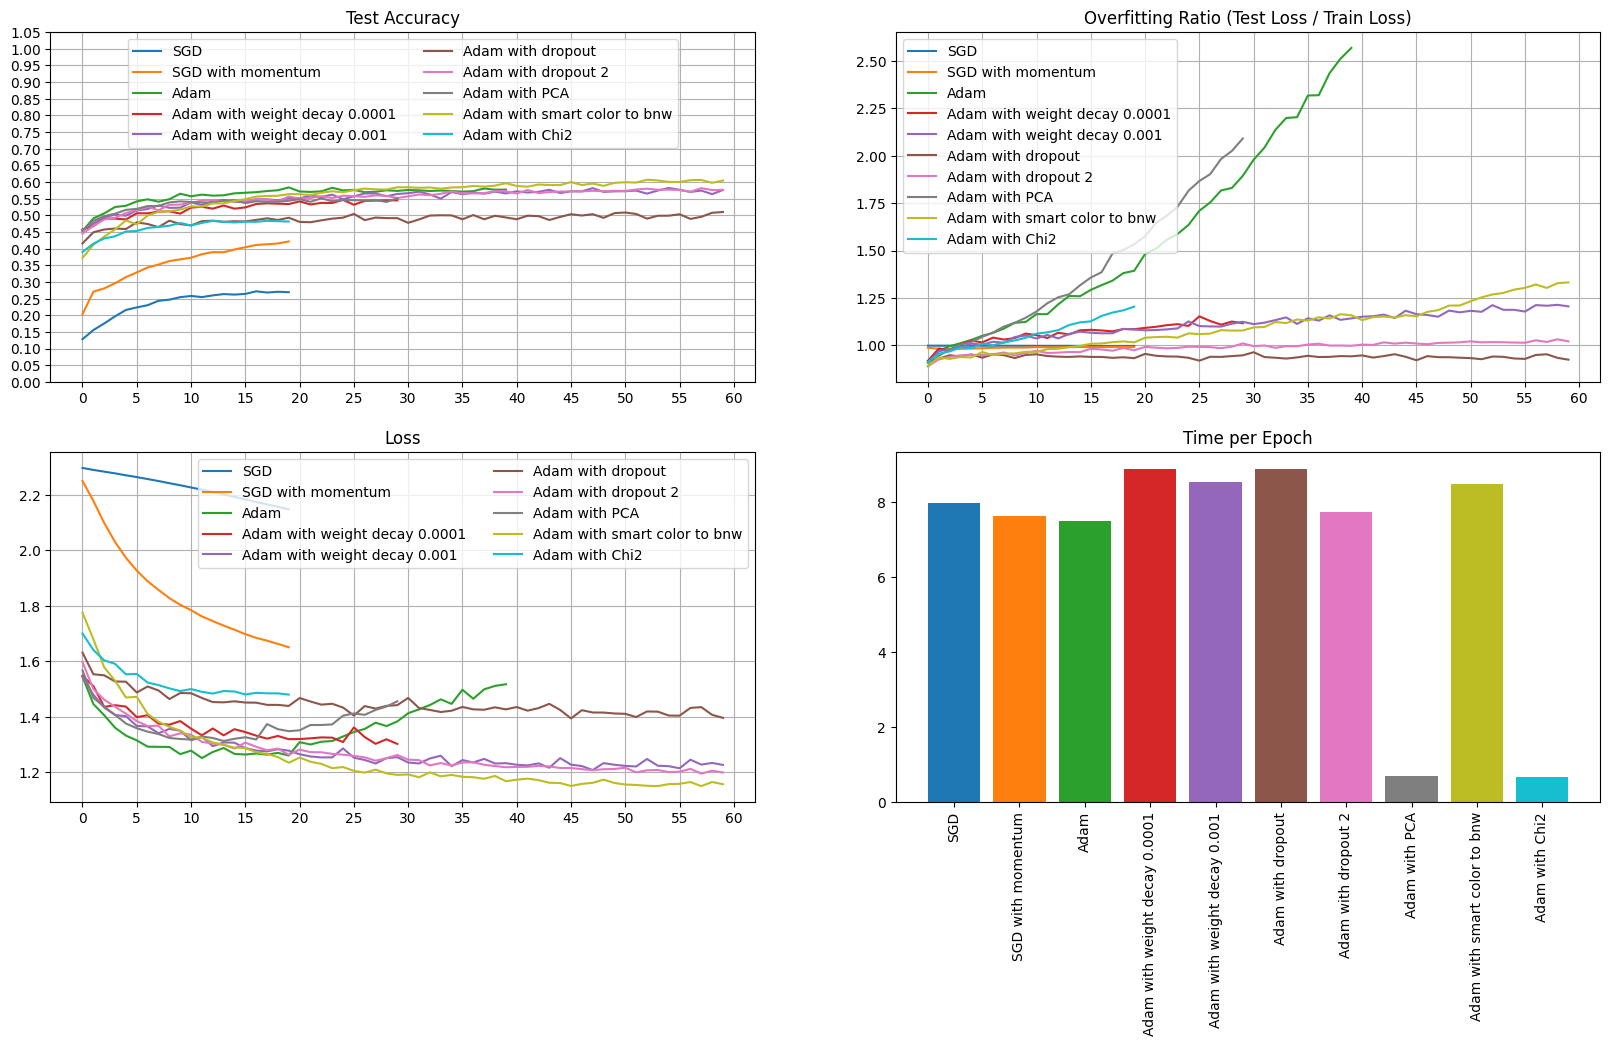

In [246]:
compare_accuracy_and_overfitting_and_time(
    {
        "SGD" : history_default,
        "SGD with momentum" : history_momentum,
        "Adam" : history_adam,
        "Adam with weight decay 0.0001" : history_adam_wd,
        "Adam with weight decay 0.001" : history_adam_wd_2,
        "Adam with dropout" : history_adam_dropout,
        "Adam with dropout 2" : history_adam_dropout_2,
        "Adam with PCA" : history_pca,
        "Adam with smart color to bnw" : history_smart,
        "Adam with Chi2" : history_chi2
    }
)

Now we can move on to combining the techniques used, using the cross-validation method. First we will define the hyperparameters we are interested in.

In [91]:
pca_ratios = [0.1, 0.33] # 10% and 33% of the original number of features with PCA
learning_rates = [0.0001]
weight_decays = [0.0, 0.0001]
batch_sizes = [512]
layers = [1, 3]
dropouts = [0.2, 0.5]

# more values can be added to the lists above, but they were kept short for the sake of time

Then some helpers

In [ ]:
def get_setup(lr, wd, l, d, pca_ratio):
    features = int(DIM*DIM*CHANNELS*pca_ratio)

    model = nn.Sequential()
    model.add_module('flatten', nn.Flatten())
    layers_features = lambda x: features//(x-1) if x > 1 else features
    for i in range(l):
        model.add_module(f'linear_{i}', nn.Linear(layers_features(i-1), layers_features(i)))
        model.add_module(f'relu_{i}', nn.ReLU())
        model.add_module(f'dropout_{i}', nn.Dropout(d))

    model.add_module('linear_last', nn.Linear(layers_features(l-1), CLASSES))
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    return model, optimizer

def get_setup_tuple(lr, wd, bs, l, d, pca_ratio):
    return (lr, wd, bs, l, d, pca_ratio)

The data is split into folds, and each set of hyperparameters is evaluated on all folds. The performance is then averaged and the setup with the highest average test accuracy is kept.

In [93]:
def cross_validation(learning_rates, weight_decays, layers, dropouts, batch_sizes, pca_ratios, num_folds = 3):
    global V, mean_train, cifar_len

    total = len(learning_rates)*len(weight_decays)*len(layers)*len(dropouts)*len(batch_sizes)*len(pca_ratios)

    kf = KFold(n_splits=num_folds, shuffle=True)

    trainloader = get_loaders(cifar_len)[0]

    data_train, labels_train = next(iter(trainloader))
    
    history = {}

    best_accuracy = 0.0
    best_setup = None

    i = 0
    for pca_ratio in pca_ratios:

        # this part is for the PCA
        features = int(DIM*DIM*CHANNELS*pca_ratio)
        V_reduced = V[:, :features]
        data_train = data_train.view(len(data_train), -1)  # Flatten the images
        data_train = data_train - mean_train

        pca_train = torch.matmul(data_train, V_reduced)

        x_pca_train = pca_train.float().to(DEVICE)
        y_pca_train = labels_train.long().to(DEVICE)

        trainset = torch.utils.data.TensorDataset(x_pca_train, y_pca_train)
        #############################

        for lr, wd, bs, l, d in product(learning_rates, weight_decays, batch_sizes, layers, dropouts):
            i = i + 1

            print(f"Running setup: lr={lr}, wd={wd}, bs={bs}, l={l}, d={d}, pca_ratio={pca_ratio}")
            print(f"We are at step {i}/{total}")

            setup_tup = get_setup_tuple(lr, wd, bs, l, d, pca_ratio)

            if setup_tup not in history:
                history[setup_tup] = []

            for train_index, test_index in kf.split(trainset):
                    trainset_fold = torch.utils.data.Subset(trainset, train_index)
                    testset_fold = torch.utils.data.Subset(trainset, test_index)

                    trainloader_fold = torch.utils.data.DataLoader(trainset_fold, batch_size=bs, shuffle=True)
                    testloader_fold = torch.utils.data.DataLoader(testset_fold, batch_size=bs, shuffle=False)

                    model, optimizer = get_setup(lr, wd, l, d, pca_ratio)
            
                    history_fold = train_model(model, trainloader_fold, testloader_fold, optimizer, epochs=30, verbose=False)
            
                    history[setup_tup].append(history_fold)

            avg_accuracy = np.mean([history_fold['test_accuracy'][-1] for history_fold in history[setup_tup]])

            print(f'Average accuracy for setup {setup_tup}: {avg_accuracy:.3f}')
            
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_setup = setup_tup

    return history, best_setup, best_accuracy


The best combination of values will be determined using cross-validation

In [199]:
history, best_setup, best_accuracy = cross_validation(learning_rates, weight_decays, layers, dropouts, batch_sizes, pca_ratios)
print(f"Best setup: {best_setup}, with accuracy: {best_accuracy}")

Best setup: (0.0001, 0.0, 3, 0.2, 0.33), with accuracy: 0.5176599480130882

Files already downloaded and verified
Running setup: lr=0.0001, wd=0.0, bs=512, l=1, d=0.2, pca_ratio=0.1
We are at step 1/16
Average accuracy for setup (0.0001, 0.0, 1, 0.2, 0.1): 0.440
Running setup: lr=0.0001, wd=0.0, bs=512, l=1, d=0.5, pca_ratio=0.1
We are at step 2/16
Average accuracy for setup (0.0001, 0.0, 1, 0.5, 0.1): 0.428
Running setup: lr=0.0001, wd=0.0, bs=512, l=3, d=0.2, pca_ratio=0.1
We are at step 3/16
Average accuracy for setup (0.0001, 0.0, 3, 0.2, 0.1): 0.471
Running setup: lr=0.0001, wd=0.0, bs=512, l=3, d=0.5, pca_ratio=0.1
We are at step 4/16
Average accuracy for setup (0.0001, 0.0, 3, 0.5, 0.1): 0.438
Running setup: lr=0.0001, wd=0.0001, bs=512, l=1, d=0.2, pca_ratio=0.1
We are at step 5/16
Average accuracy for setup (0.0001, 0.0001, 1, 0.2, 0.1): 0.440
Running setup: lr=0.0001, wd=0.0001, bs=512, l=1, d=0.5, pca_ratio=0.1
We are at step 6/16
Average accuracy for setup (0.0001, 0.0001, 

And then a model will be trained on the full set of data, and it's accuracy will be gauged.

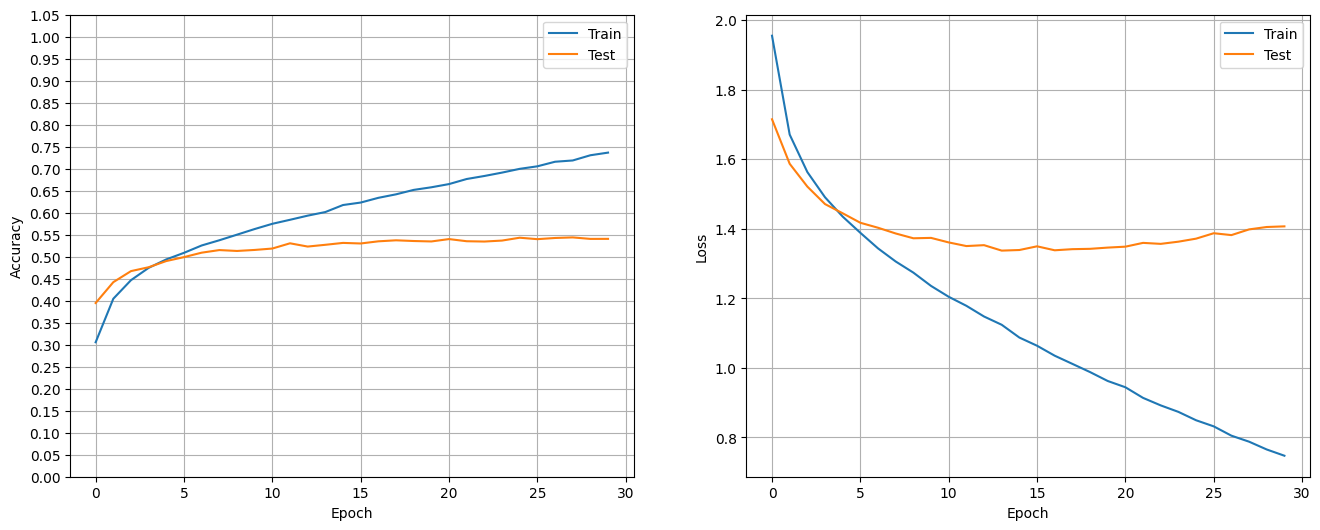

In [239]:
lr, wd, bs, l, d, pca_ratio = best_setup

features = int(DIM*DIM*CHANNELS*pca_ratio)
V_reduced = V[:, :features]

trainloader, testloader = get_loaders(cifar_len)

data_train, labels_train = next(iter(trainloader))
data_test, labels_test = next(iter(testloader))

data_train = data_train.view(len(data_train), -1)  # Flatten the images
data_train = data_train - mean_train
data_test = data_test.view(len(data_test), -1)  # Flatten the images
data_test = data_test - mean_train

pca_train = torch.matmul(data_train, V_reduced)
pca_test = torch.matmul(data_test, V_reduced)

x_pca_train = pca_train.float().to(DEVICE)
y_pca_train = labels_train.long().to(DEVICE)

x_pca_test = pca_test.float().to(DEVICE)
y_pca_test = labels_test.long().to(DEVICE)

trainset = torch.utils.data.TensorDataset(x_pca_train, y_pca_train)
testset = torch.utils.data.TensorDataset(x_pca_test, y_pca_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

model, optimizer = get_setup(lr, wd, l, d, pca_ratio)
models["Best cross validation"] = model

history_best = train_model(model, trainloader, testloader, optimizer, epochs=30, verbose=True)

plot_accuracy_loss(history_best)


Due to the restraints of the values set before, the model is not the best we've seen yet.

### Section three: CNNs

The geometrically structured nature of the dataset makes it more suitable for a network that understands the relative positions of the inputs, and assumes a relationship between nearby pixels.

In [99]:
model_3 =  nn.Sequential(
    # Convolutional layer 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32x32x3 -> 32x32x32
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                         # 32x32x32 -> 16x16x32
    nn.BatchNorm2d(32),
    
    # Convolutional layer 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),# 16x16x32 -> 16x16x64
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                         # 16x16x64 -> 8x8x64
    nn.BatchNorm2d(64),

    # Prepare for linear layer
    nn.Flatten(),                               # 8x8x64 -> 4096

    # Dense layer
    nn.Linear(64 * 8 * 8, 64),                  # 4096 -> 64
    nn.ReLU(),
    nn.Dropout(0.5),

    # Output layer
    nn.Linear(64, 10)                           # 64 -> 10  
).to(DEVICE)

models["CNN"] = model_3

This network will be trained with the same optimizer used before, with a smaller batch size, as this is useful for CNNs.

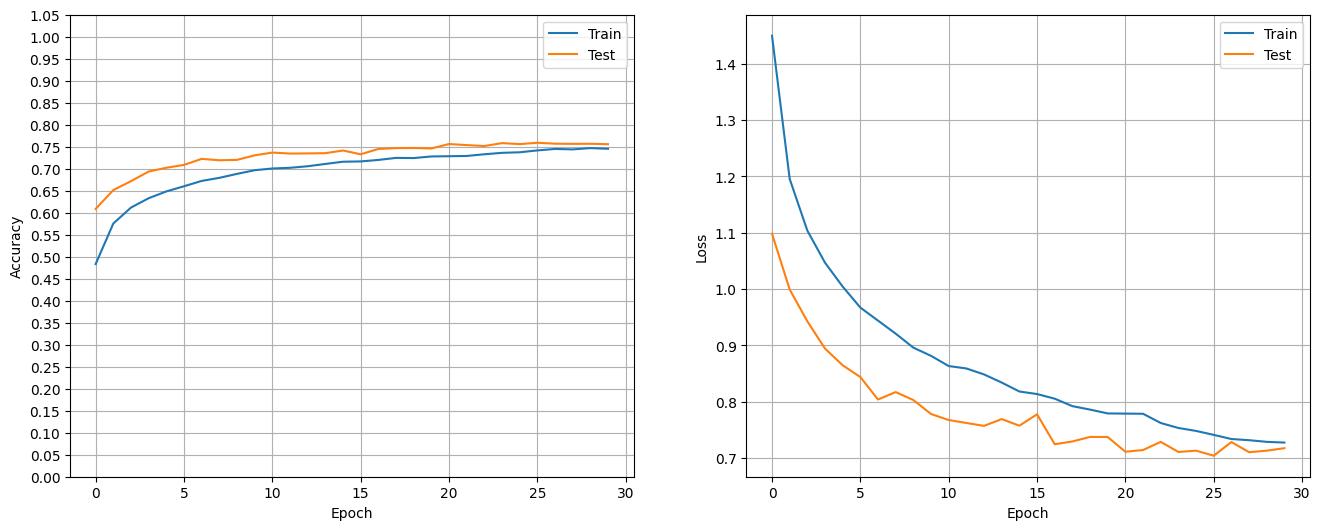

In [193]:
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)
epochs_3 = 30
batch_size_3 = 64

trainloader, testloader = get_loaders(batch_size=batch_size_3)

with Timer():
    history_cnn = train_model(model_3, trainloader, testloader, optimizer_3, epochs=epochs_3, verbose=False, history=history_cnn)

plot_accuracy_loss(history_cnn)

It is obvious that this network is much more suited to the task, as it reaches a higher accuracy with little optimization.

The following are some images that the CNN got wrong:

Files already downloaded and verified


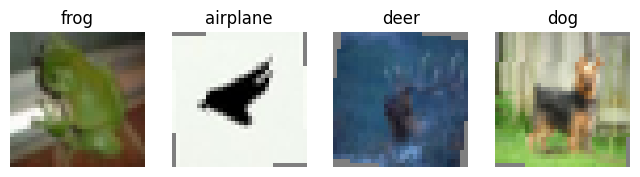

In [194]:
# wrong images from the cnn:
_, testloader = get_loaders(batch_size=256)

model_3.eval()
inputs, labels = next(iter(testloader))

inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

outputs = model_3(inputs.to(DEVICE))

_, predicted = torch.max(outputs.data, 1)

wrong_images = inputs[predicted != labels]
wrong_labels = labels[predicted != labels]

# unnormalize the images
wrong_images = wrong_images + abs(wrong_images.min())
wrong_images = wrong_images / wrong_images.max()

show_images(wrong_images.cpu().permute(0, 2, 3, 1), wrong_labels.cpu(), testset.classes, n_images=4)


And here are some images the model got right

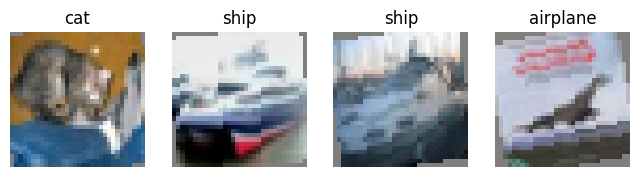

In [195]:
correct_images = inputs[predicted == labels]
correct_labels = labels[predicted == labels]

# unnormalize the images
correct_images = correct_images + abs(correct_images.min())
correct_images = correct_images / correct_images.max()

show_images(correct_images.cpu().permute(0, 2, 3, 1), correct_labels.cpu(), testset.classes, n_images=4)

To get a better sense we might peek at the confusion matrix.

Files already downloaded and verified


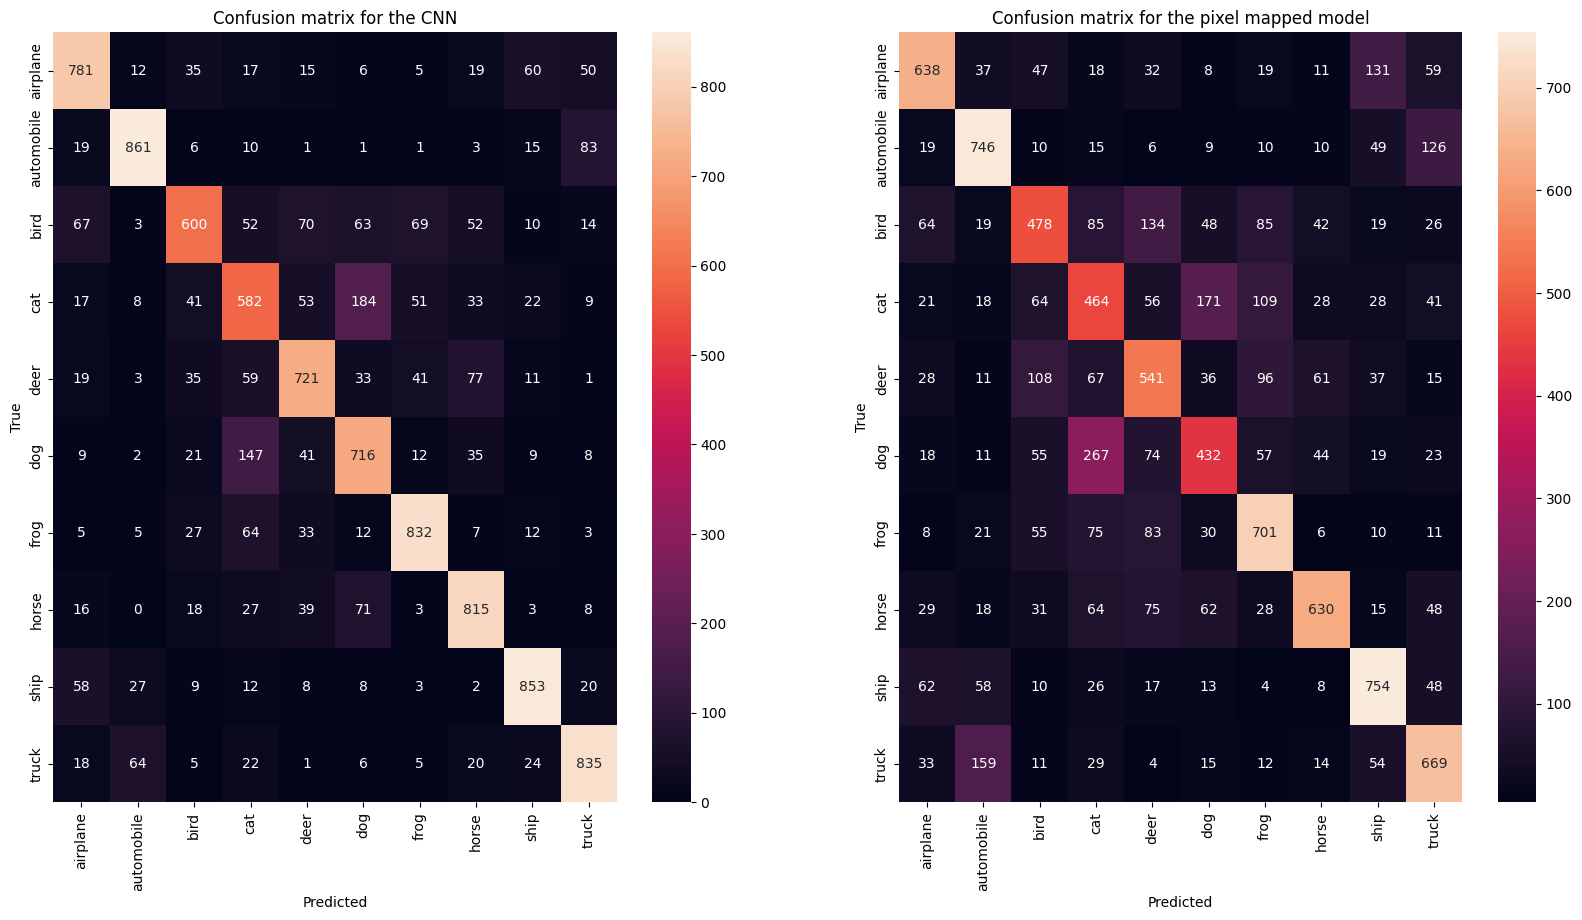

In [229]:
from sklearn.metrics import confusion_matrix

trainloader, testloader = get_loaders(batch_size=1024)

model_3.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model_3(inputs)

        _, predicted = torch.max(outputs.data, 1)

        predictions += predicted.tolist()
        true_labels += labels.tolist()

cm = confusion_matrix(true_labels, predictions)

import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Confusion matrix for the CNN')
sn.heatmap(cm, annot=True, fmt='g', xticklabels=testset.classes, yticklabels=testset.classes)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
plt.title('Confusion matrix for the pixel mapped model')

model_2_3.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model_2_3(inputs)

        _, predicted = torch.max(outputs.data, 1)

        predictions += predicted.tolist()
        true_labels += labels.tolist()

cm = confusion_matrix(true_labels, predictions)

sn.heatmap(cm, annot=True, fmt='g', xticklabels=testset.classes, yticklabels=testset.classes)

plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()


Across the board, the CNN is performing better, (it sees more horses in frogs so it is not better for EVERY task...)

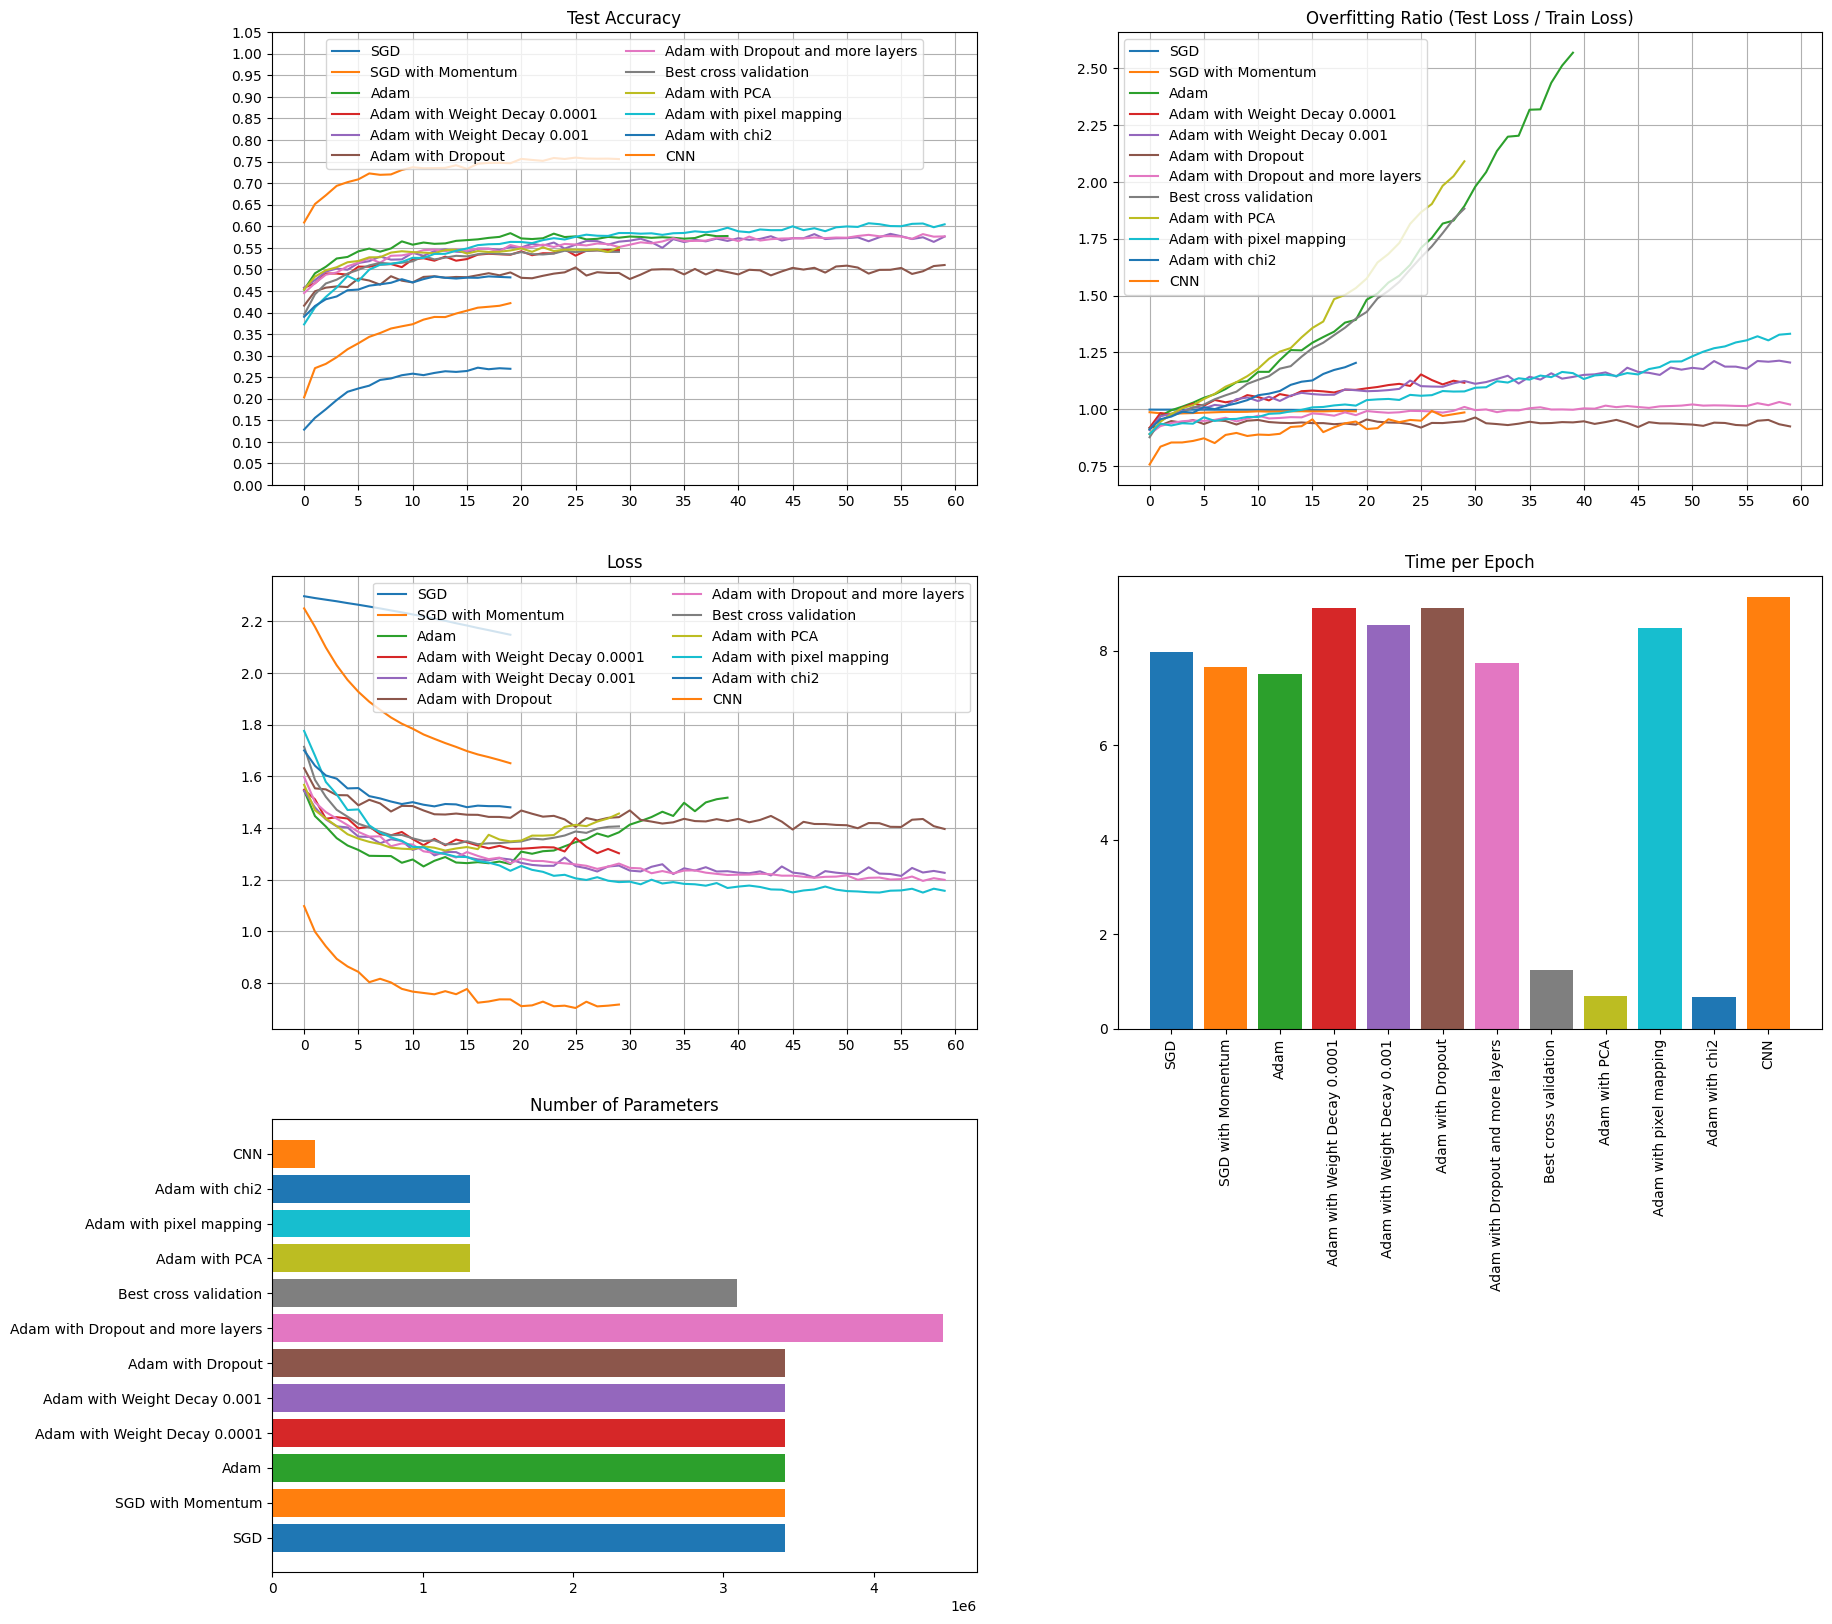

In [242]:
compare_accuracy_and_overfitting_and_time_and_parameters(
    {
        "SGD" : history_default,
        "SGD with Momentum" : history_momentum,
        "Adam" : history_adam,
        "Adam with Weight Decay 0.0001" : history_adam_wd,
        "Adam with Weight Decay 0.001" : history_adam_wd_2,
        "Adam with Dropout" : history_adam_dropout,
        "Adam with Dropout and more layers" : history_adam_dropout_2,
        "Best cross validation" : history_best,
        "Adam with PCA" : history_pca,
        "Adam with pixel mapping" : history_smart,
        "Adam with chi2" : history_chi2,
        "CNN" : history_cnn
    },
    models
)

Amazingly, the best performing models have the least parameters. It is worth noting that they both utilize information in a more context-aware fashion. 

And as gathered from the 1/2 project, the accuracies using KNN and NC are:

KNN(1) accuracy (colored) = 0.3539
KNN(1) accuracy (black and white) = 0.3041
KNN(3) accuracy (colored) = 0.3303
KNN(3) accuracy (black and white) = 0.2779
NC accuracy (colored) = 0.2774
NC accuracy (black and white) = 0.242

So they are surpassed with every model.

### Thank you for your attention!